In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Linear Regression and Prediction

If the data seems to follow a linear model with equal variance, then we can use bootstrap methods to predict values of new data points. For instance in the BMI vs Blood Pressure data, we might want to try to predict a diabetes patients Blood Pressure using their BMI. 

Given our regression line of $y = 1.24+62x$, one could naively predict that the Blood Pressure of a patient with a BMI of $20.5$ is $1.24+62(20.5) = 87.42$. However, that is unlikely to be the exact value. For that reason it is better to build an interval of likely values for the blood pressure.

To build this prediction interval for $y_{\textrm{new}}$ given a particular value of $x_{\textrm{new}}$. We first, get bootstrap sample of the data. Next, we then build a regression line for the bootstrapped data, then sample a residual from our bootstrapped data and add that to the predict value $a+bx_{\textrm{new}}$.

Repeating this for a given number of bootstrap samples, we then use quantiles to get an interval for "reasonable" values of $y$.

The function below will do this given $x_{\textrm{new}}$, the original data sets, and the number of bootstrap samples to take.

In [4]:
def ols(x,y):
    """ Compute slope of OLS for two np.arrays"""
    #initialize to to NaN, incase we can't compute slope.
    b,a = float("NaN"),float("NaN")
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    b = sum((x-x_bar)*(y-y_bar))/sum((x-x_bar)**2)
    a = y_bar-b*x_bar
    return np.array([b,a])

diabetes = pd.read_csv("diabetes.tsv",delimiter="\t")

In [5]:
def predictionInterval(df,x_col,y_col,x_new,iterations):
    # Given a dataframe, df, the name of columns x_col and y_col, 
    # the x value of a new data point, x_new, and a number of bootstrap iterations, iterations.
    # This function returns a 95% prediction interval for the value of y_new
    predicted_values=[]
    for i in range(iterations):
        #Get bootstrap sample
        df.sample(n=len(df),replace=True)
        # compute regression line
        boot_reg = ols(df[x_col],df[y_col])
        # compute residuals for boot strap regression line
        boot_residuals = df[y_col] - df[x_col]*boot_reg[0]-boot_reg[1]
        # sample a residual
        res = np.random.choice(boot_residuals,size=1)
        # store predicted value
        predicted_values.append(res+x_new*boot_reg[0]+boot_reg[1])
    return [np.percentile(predicted_values,2.5),np.percentile(predicted_values,97.5)]

Using the prediction interval function, and applying it to our diabetes data set. We get an interval of [62.8,113.2], this means that for new diabetes patients with a BMI of 20.5, we expect them to have a blood pressure of between 63.9 and 112.8 around 95\% of the time. 
Though it should be noted in practice that more our original data set differs from the true population the worse our prediction interval will preform in practice.

In [6]:
np.random.choice(1)
predictionInterval(diabetes,"BMI","BP",20.5,1000)

[63.478277044879455, 110.77184211925297]

## Other Model Concerns

Just because a data set appears to follow a linear model with equal variance, doesn't mean the corresponding regression line and it's diagnostics won't have problems. There are a few properties of a data set that could cause issues with Hypothesis Tests and Confidence Intervals. This list isn't exhaustive of all issues that might affect validity of a linear model, but contains several things to watch out for and how they might affect the model.

## Outliers

An Outlier is a data point $(x_i,y_i)$ where $y_i$ is far away from the value predicted by the regression model. In other terms the residual $\epsilon_i = y_i - (a+bx_i)$ is extreme compared to the other residuals. The example below shows the effect the presence of outliers can have on a regression. While the regression line is nearly unchanged the outlier drops the $R^2$ value quite a bit.

If an outlier can be determined to be caused by an error in data collection, it is often best practice to remove them. However, removal of outliers should not be your default practice as it can indicate the presence of inadequacies in the model. 

The example below has $100$ simulated data points including a single outlier. While the regression line is nearly unchanged the $R^2$ value is significantly lower. 

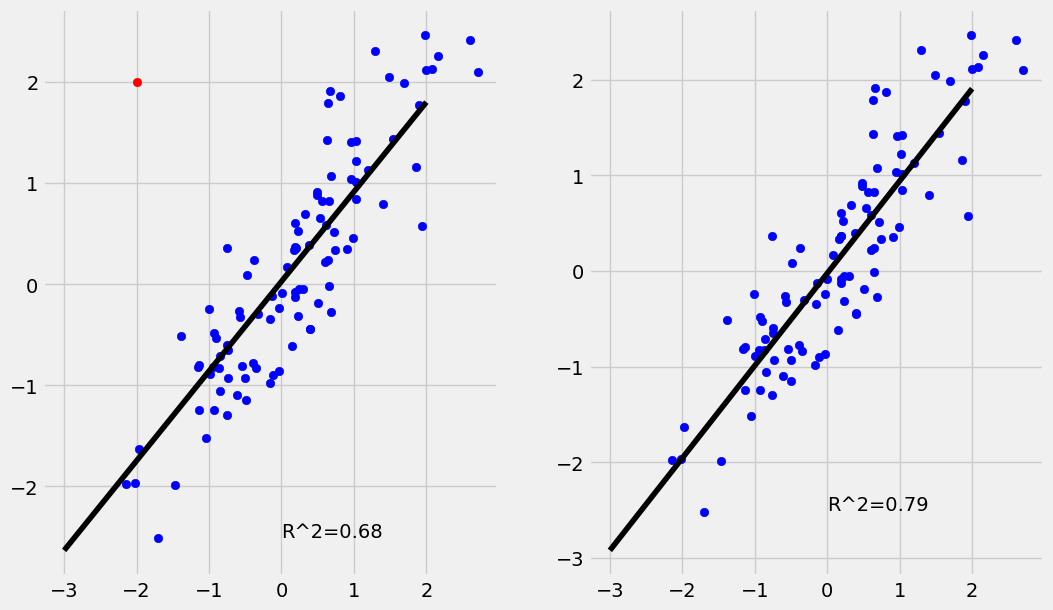

In [7]:
fig, axs = plt.subplots(1, 2);
np.random.seed(101)
x = np.random.normal(0,1,99)
y = x+ np.random.normal(0,0.5,99)
out = [[-2],[2]]
x_out = np.append(x,out[0])
y_out = np.append(y,out[1])
        
axs[0].scatter(x,y,color="blue")
axs[0].scatter(out[0],out[1],color="red")
lin_out = np.poly1d(np.polyfit(x_out,y_out,1))
r_out = np.corrcoef(x_out,y_out)[0,1]
axs[0].text(x=0,y=-2.5,s="R^2={}".format(round(r_out**2,2)));
axs[0].plot(np.arange(-3,3),lin_out(np.arange(-3,3)),color="black")


axs[1].scatter(x,y,color="blue")
lin = np.poly1d(np.polyfit(x,y,1))
r = np.corrcoef(x,y)[0,1]
axs[1].text(x=0,y=-2.5,s="R^2={}".format(round(r**2,2)));
axs[1].plot(np.arange(-3,3),lin(np.arange(-3,3)),color="black")

fig.set_size_inches(11.5, 7)
plt.show()

## High Leverage Points

A high leverage point is a point $(x_i,y_i)$ where $x_i$ is an extreme value. Note that this is a similar though distinct concept from the definition of outlier given above. Unlike with outliers, high leverage points can have a substantial impact on the regression line. This should be a cause for concern, as that any issues with the high leverage data point will have an outsize influence on the regression line. Additionally, any trend present in the rest of the data may be lost due to the influence of the high leverage point.

The plots below shows what happens when $1$ or $2$ high leverage points (in red) are added to an uncorrelated data set of $100$ points.

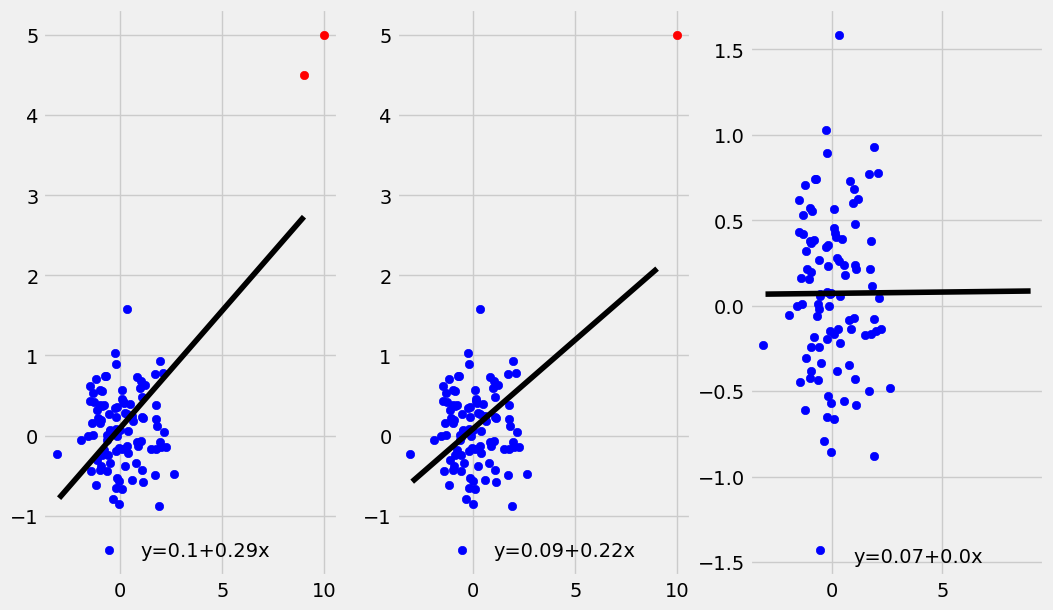

In [8]:
fig, axs = plt.subplots(1, 3);

fig.set_size_inches(11.5, 7)
np.random.seed(176)
x = np.random.normal(0,1,99)
y = np.random.normal(0,0.5,99)
hlp1 = [[10],[5]]
hlp2 = [[9],[4.5]]
x_hlp = np.append(x,hlp1[0])
y_hlp = np.append(y,hlp1[1])
x_hlp2 = np.append(x_hlp,hlp2[0])
y_hlp2 = np.append(y_hlp,hlp2[1])
        

        
axs[0].scatter(x,y,color="blue")
axs[0].scatter(hlp1[0],hlp1[1],color="red")
axs[0].scatter(hlp2[0],hlp2[1],color="red")
coeffs_hlp2 = np.polyfit(x_hlp2,y_hlp2,1)
a_hlp2=round(coeffs_hlp2[0],2)
b_hlp2=round(coeffs_hlp2[1],2)
lin_hlp = np.poly1d(np.polyfit(x_hlp2,y_hlp2,1))
axs[0].text(x=1,y=-1.5,s="y="+str(b_hlp2) + "+" + str(a_hlp2)+"x");
axs[0].plot(np.arange(-3,10),lin_hlp(np.arange(-3,10)),color="black")


axs[1].scatter(x,y,color="blue")
axs[1].scatter(hlp1[0],hlp1[1],color="red")
coeffs_hlp = np.polyfit(x_hlp,y_hlp,1)
a_hlp=round(coeffs_hlp[0],2)
b_hlp=round(coeffs_hlp[1],2)
lin_hlp = np.poly1d(np.polyfit(x_hlp,y_hlp,1))
axs[1].text(x=1,y=-1.5,s="y="+str(b_hlp) + "+" + str(a_hlp)+"x");
axs[1].plot(np.arange(-3,10),lin_hlp(np.arange(-3,10)),color="black")


axs[2].scatter(x,y,color="blue")
coeffs = np.polyfit(x,y,1)
a=round(coeffs[0],2)
b=round(coeffs[1],2)
lin = np.poly1d(coeffs)
axs[2].text(x=1,y=-1.5,s="y="+str(b) + "+" + str(a)+"x");
axs[2].plot(np.arange(-3,10),lin(np.arange(-3,10)),color="black")
plt.show()

## Correlated Errors

The last condition we'll discuss is the most technical. Correlated errors occur when the residual, $y_i - (a+x_ib)$ of a point $(x_i,y_i)$ is correlated with the residual of other points with similar $x$ values. For instance, imagine if in the diabetes data, we took measurements from the same patient over the course of 10 days, and included that all in one data set. Since both BMI and Blood Pressure aren't going to change that much from day to day, we would've effectively increased the size of our data set by 10, however each new point is going to be very close to an old data point. 

Correlated Errors are a problem because they can cause us to overstate the strength and statistical significance of an relationship.

In an extreme case, if we have two data points $(x_1,y_1)$ and $(x_2,y_2)$ the regression line will be the line between them and the $p$-value given by a two-sided permutation test will be $p=1.0$ a statistically insignificant result. If we instead make 5 copies of each point, and the regression line will stay the same, but a permutation test will return a $p$-value of less than $0.01$, a highly statistically significant result.

Many techniques have been developed to handle data with correlated errors, a lot of which are outside the scope of this book. The best method, when available, is to design the experiment or data collection process to eliminate or minimize potential correlated errors. 

In [9]:
def ols(x,y):
    """ Compute slope of OLS for two np.arrays"""
    #initialize to to NaN, incase we can't compute slope.
    beta,alpha = float("NaN"),float("NaN")
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    beta = sum((x-x_bar)*(y-y_bar))/sum((x-x_bar)**2)
    alpha = y_bar-beta*x_bar
    return np.array([beta,alpha])

x = [0,1]*5
y = [1,2]*5
sample_slope = ols(x,y)[0]
null_slopes=[]

for i in range(10000):
    # single bootstrap resample
    shuffled_y = np.random.choice(y,len(y),replace=False)
    # compute statistic
    shuffled_slope = ols(x,shuffled_y)[0]
    #store permuted slope
    null_slopes.append(shuffled_slope)

#compute $p$-value for two sided test
#print("sample_slope",sample_slope)
#print(null_slopes)
(sum(np.abs(np.array(null_slopes)) >= sample_slope))/10000;

One way correlated errors can arise is due to cluster sampling. For instance, let's say I conduct a study, that aims to investigate the relationship between height and socioeconomic status. In particular, I choose 100 families around the country and interview every adult member of each family recording their height and annual income. Getting around 400 data points. 

Then since people in the same family are likely to be of similar heights, due to genetics, similarities in childhood nutrition, etc. and similar annual incomes (due to similar access to education, investment capital, etc.) this would be a strong source of correlated errors. 

## Other Objective Functions


Recall we found the ordinary least squares regression line, $y=a+b*x$ by finding the values of $a$ and $b$ that minimized the residual sum of squares,

$$\textrm{RSS}(a,b) = \sum_{i=1}^n (y_i-(a+b*x_i))^2.$$

We found this via the use of formulas. 

However, other objective functions can and are used in practice. As mentioned a common one is the Sum of Absolute Errors 

$$\textrm{SAE}(a,b) = \sum_{i=1}^n \left| y_i - (a+b*x_i)\right|.$$

With these other objective functions there usually isn't a formula for the solution and it has to be found with other methods. We can find the solution to these loss functions using the function minimize from the scipy module.

The regression found by minimizing the SAE is the Least Absolute Deviation (LAD) regression line.

In [16]:
from scipy.optimize import minimize
# here coeffs are the values a and b, that we are trying to find.
# X and Y constitute the dataset
def sae_loss(coeffs,X,Y):
    """Returns the sum of absolute errors for the line defined by coeffs"""
    slope = coeffs[0]
    intercept = coeffs[1]
    resids = (Y-(intercept+slope*X))
    return np.sum(np.abs(resids))
              
#The powell method is good here, because SAE isn't always differentiable.
result = minimize(sae_loss,x0=[0,0],args=(diabetes["BMI"],diabetes["BP"]),method="Powell")
result.x

array([ 1.61355833, 51.20025882])

The above shows that the LAD regression line is given by 

$$BP = 1.61*BMI+51.2.$$

We plot that with the OLS regression line below.


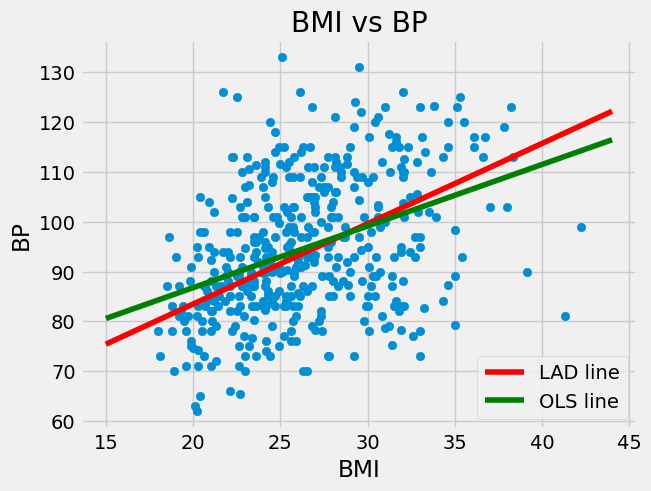

In [20]:
ols_line = ols(diabetes.BMI,diabetes.BP)
plt.scatter(diabetes.BMI,diabetes.BP)
xs = np.arange(15,45)
plt.plot(xs,result.x[0]*xs+result.x[1],color="red",label="LAD line")

plt.plot(xs,ols_line[0]*xs+ols_line[1],color="green",label="OLS line")
plt.title("BMI vs BP")
plt.xlabel("BMI")
plt.ylabel("BP")
plt.legend()
plt.show()

It may seem strange that these are different given that the Sum of Absolute Deviations and Residual Sum of Squares seem very similar. One reason that they are different is that the LAD regression line is actually an estimate for something else.

Where as you may recall that the OLS regression line, gives an estimate for the conditional mean $\mu_{Y \mid X}$. It turns out that the LAD regression line gives an estimate for the condition median $M_{Y\mid X}$.